In [63]:
import math
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import ValidationCurveDisplay
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [87]:
def load_data():
    
    df = pd.read_csv('./heart.csv')
    df.describe()
        #First we need to turn the categorical data into numbers
    #for sex, M = 0, F = 1
    df['Sex'] = df['Sex'].transform(lambda sex: 0 if sex == 'M' else 1)
    
    df['ChestPainType'].unique()
    #ATA = 0, NAP = 1, ASY = 2, TA = 3
    df['ChestPainType'] = df['ChestPainType'].transform(lambda pain_type: 0 if pain_type == 'ATA' else 1 if pain_type == 'NAP' else 2 if pain_type == 'ASY' else 3)
    
    #restingECG Normal = 0, ST(ST-T wave abnormality) = 1, LVH(probably or definite left ventricular hypertrophy) = 2
    df['RestingECG'] = df['RestingECG'].transform(lambda ecg: 0 if ecg == 'Normal' else 1 if ecg == 'ST' else 2)
    
    #Exercise Angina (chest pain)
    #Y = 1, N = 0
    df['ExerciseAngina'] = df['ExerciseAngina'].transform(lambda angia: 0 if angia == 'N' else 1)
    
    #ST Slope
    #up = 0, flat = 1, down = 2
    df['ST_Slope'] = df['ST_Slope'].transform(lambda slope: 0 if slope == 'Up' else 1 if slope == 'Flat' else 2)

    return df[df['HeartDisease'] == 1].drop('HeartDisease', axis=1)

def seperate_columns():
    data = load_data()
    return data.drop('Sex', axis=1), data['Sex'] 
def split_data(s=.2):
    data = load_data()
    return train_test_split(data.drop('Sex', axis=1), data['Sex'], random_state = 0, test_size=s)
    
def get_max_test_score_idx(plot):
    mean_scores = plot.test_scores.mean(axis=1)
    return mean_scores.argmax(), mean_scores.max()

def evaluate_sk(model, test_sizes, X, Y, file_name, title):
    test_results, train_results = [], []
    for size in test_sizes:
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=size, random_state=0)
        model.fit(x_train, y_train)
        test_results.append(model.score(x_test, y_test))
        train_results.append(model.score(x_train, y_train))

    plt.title(title)

    plt.plot(train_results, label='Train')
    plt.plot(test_results, label='Test')
    plt.xticks([i * 10 for i in test_sizes], test_sizes + [])
    plt.ylim((.1, 1.1))

    plt.legend()
    plt.savefig(file_name)
    plt.show()
    plt.clf()

In [88]:
#some quick exploration
df = load_data()

print(df.corr())

for col in df.columns:
    print(f'{col} has {df[col].unique()} values')

                     Age       Sex  ChestPainType  RestingBP  Cholesterol  \
Age             1.000000  0.010626      -0.051401   0.260211    -0.041392   
Sex             0.010626  1.000000      -0.036249   0.130351     0.124032   
ChestPainType  -0.051401 -0.036249       1.000000  -0.031333    -0.025267   
RestingBP       0.260211  0.130351      -0.031333   1.000000     0.167097   
Cholesterol    -0.041392  0.124032      -0.025267   0.167097     1.000000   
FastingBS       0.096688 -0.010255       0.039604   0.028124    -0.295467   
RestingECG      0.222015  0.021533      -0.030801   0.132852     0.157762   
MaxHR          -0.246705  0.143745      -0.042075  -0.112153     0.187556   
ExerciseAngina  0.062735 -0.055910       0.079027   0.158327     0.136766   
Oldpeak         0.126277  0.017741       0.068119   0.155366     0.210180   
ST_Slope        0.079585  0.024669       0.015775   0.040884     0.045769   

                FastingBS  RestingECG     MaxHR  ExerciseAngina   Oldpeak  

(2, 0.8857697534459328)


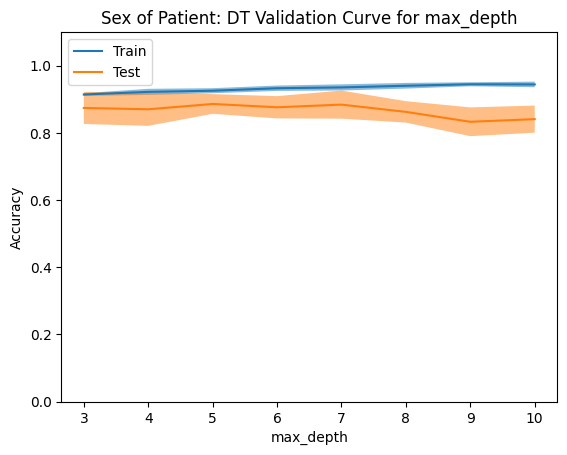

In [89]:
#start with a basic decision tree 
df = load_data()
X, Y = df.drop('Sex', axis=1), df['Sex']
plot = ValidationCurveDisplay.from_estimator(
    DecisionTreeClassifier(random_state=0, min_samples_split=10),
    X,
    Y,
    param_name="max_depth",
    param_range=[i for i in range(3, 11)],
    score_type="both",
    n_jobs=2,
    score_name="Accuracy",
)
plt.title("Sex of Patient: DT Validation Curve for max_depth")
plot.ax_.set_ylim((0, 1.1))
plt.savefig('./images/p6.1.png')
print(get_max_test_score_idx(plot))


(9, 0.8466123082896525)


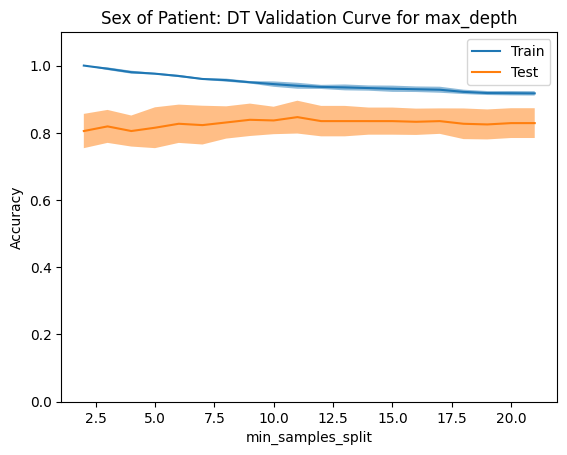

In [90]:
df = load_data()
X, Y = df.drop('Sex', axis=1), df['Sex']

plot = ValidationCurveDisplay.from_estimator(
    DecisionTreeClassifier(random_state=0),
    X,
    Y,
    param_name="min_samples_split",
    param_range=[i for i in range(2, 22)],
    score_type="both",
    n_jobs=2,
    score_name="Accuracy",
)

plt.title("Sex of Patient: DT Validation Curve for max_depth")
plot.ax_.set_ylim((0, 1.1))
plt.savefig('./images/p6.1.png')
print(get_max_test_score_idx(plot))

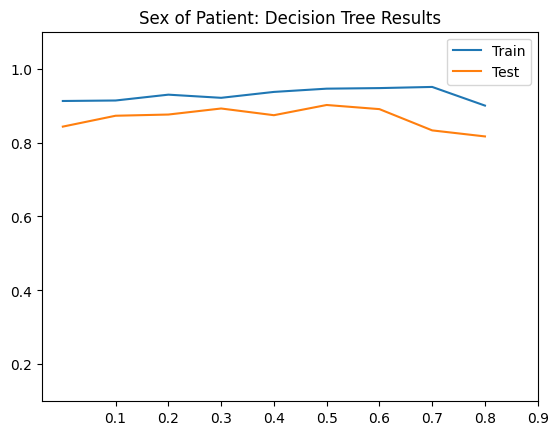

<Figure size 640x480 with 0 Axes>

In [91]:
tree = DecisionTreeClassifier(max_depth = 5, min_samples_split = 10, ccp_alpha=0.00583835, random_state=0)


evaluate_sk(tree, [i/10 for i in range(1, 10)], X, Y, './images/p6.3.png', 'Sex of Patient: Decision Tree Results')

(1, 0.8897107357794602)


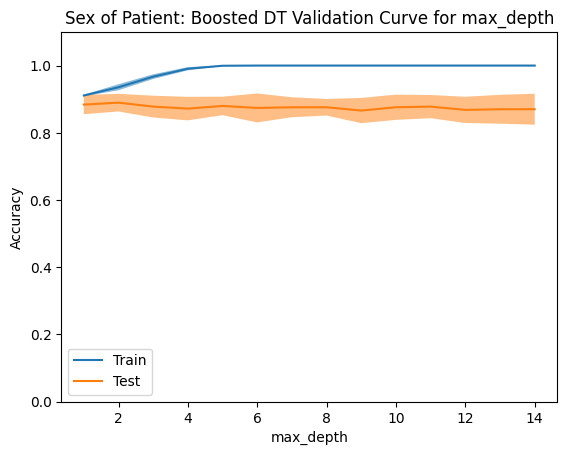

In [92]:
X, Y = seperate_columns()
clf = GradientBoostingClassifier(min_samples_split=16, verbose=1, random_state=0)

plot = ValidationCurveDisplay.from_estimator(
    clf,
    X,
    Y,
    param_name="max_depth",
    param_range=[i for i in range(1, 15)],
    score_type="both",
    n_jobs=2,
    score_name="Accuracy",
)
plt.title("Sex of Patient: Boosted DT Validation Curve for max_depth")
plot.ax_.set_ylim((0, 1.1))
plt.savefig('./images/p7.1.png')

print(get_max_test_score_idx(plot))

(14, 0.8936711318190642)


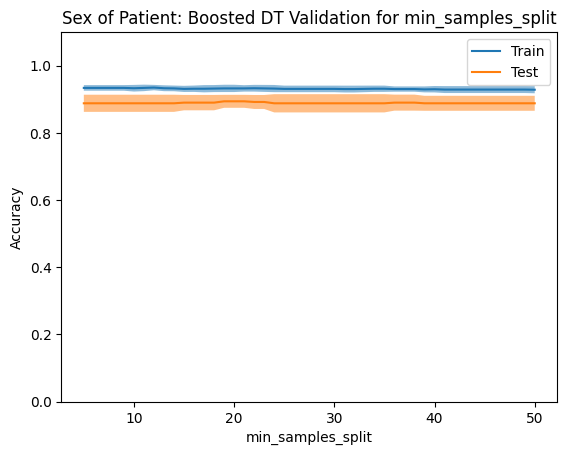

In [93]:
X, Y = seperate_columns()
clf = GradientBoostingClassifier(max_depth=2, max_features=math.ceil(math.sqrt(df.shape[1])), verbose=1, random_state=0)

plot = ValidationCurveDisplay.from_estimator(
    clf,
    X,
    Y,
    param_name="min_samples_split",
    param_range=[i for i in range(5, 51)],
    score_type="both",
    n_jobs=2,
    score_name="Accuracy",
)
plt.title("Sex of Patient: Boosted DT Validation for min_samples_split")
plot.ax_.set_ylim((0, 1.1))
plt.savefig('./images/p7.2.png')

print(get_max_test_score_idx(plot))

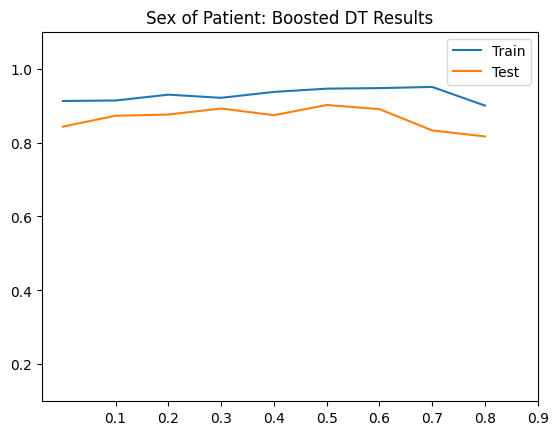

<Figure size 640x480 with 0 Axes>

In [94]:
X, Y = seperate_columns()
clf = GradientBoostingClassifier(max_depth=2, min_samples_split=16, max_features=math.ceil(math.sqrt(df.shape[1])), verbose=1, random_state=0)
evaluate_sk(tree, [i/10 for i in range(1, 10)], X, Y, './images/p7.3.png', 'Sex of Patient: Boosted DT Results')

In [95]:
from sklearn.neighbors import KNeighborsClassifier

(9, 0.9015725101921956)


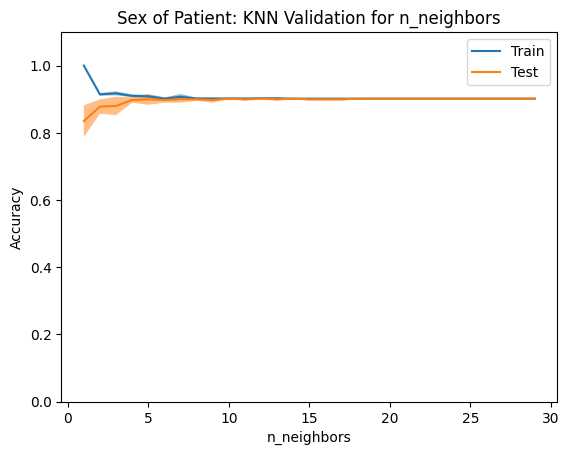

In [96]:
X, Y = seperate_columns()
neighbors = KNeighborsClassifier(algorithm='brute')
plot = ValidationCurveDisplay.from_estimator(
    neighbors,
    X,
    Y,
    param_name="n_neighbors",
    param_range=[i for i in range(1, 30)],
    score_type="both",
    n_jobs=2,
    score_name="Accuracy",
)
plt.title("Sex of Patient: KNN Validation for n_neighbors")
plot.ax_.set_ylim((0, 1.1))
plt.savefig('./images/p8.1.png')
print(get_max_test_score_idx(plot))

0.8725490196078431 0.8725490196078431


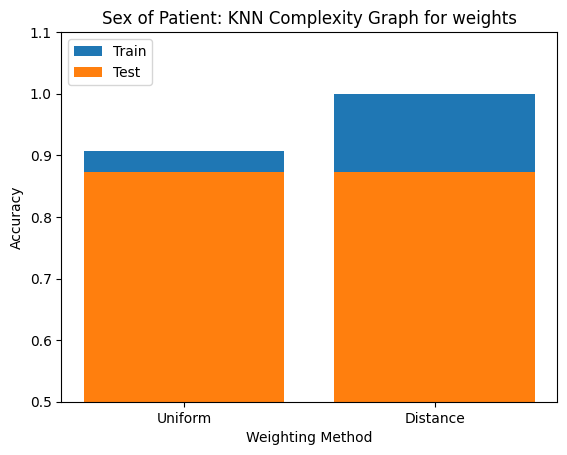

In [97]:
X, Y = seperate_columns()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=0)

distance = KNeighborsClassifier(n_neighbors=10, weights='distance').fit(x_train, y_train)
uniform = KNeighborsClassifier(n_neighbors=10, weights='uniform').fit(x_train, y_train)
uniform_train, uniform_test = uniform.score(x_train, y_train), uniform.score(x_test, y_test)
distance_train, distance_test = distance.score(x_train, y_train), distance.score(x_test, y_test)
labels = ['Uniform', 'Distance']
test, train = [uniform_test, distance_test], [uniform_train, distance_train]
plt.bar(labels, train)

plt.bar(labels, test)
plt.legend(["Train", "Test"], loc='upper left')
plt.title("Sex of Patient: KNN Complexity Graph for weights")
plt.ylim((.5, 1.1))
plt.ylabel('Accuracy')
plt.xlabel('Weighting Method')
plt.savefig('./images/p8.2.png')
print(uniform_test, distance_test)

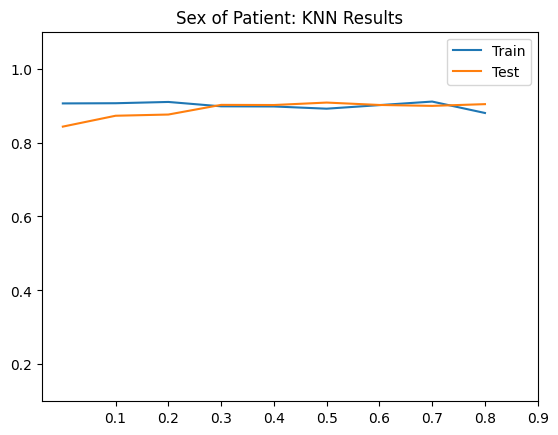

<Figure size 640x480 with 0 Axes>

In [98]:
X, Y = seperate_columns()
knn = KNeighborsClassifier(n_neighbors=10, weights='uniform')
evaluate_sk(knn, [i/10 for i in range(1, 10)], X, Y, './images/p8.3.png', 'Sex of Patient: KNN Results')

In [99]:
from sklearn import svm
X, Y = seperate_columns()
X = X.drop(['RestingBP', 'RestingECG'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=0)


vm1 = svm.SVC(kernel='poly', random_state=0, tol=.001).fit(x_train, y_train)
vm2 = svm.SVC(kernel='linear', random_state=0, tol=.001).fit(x_train, y_train)
vm3 = svm.SVC(kernel='rbf', random_state=0, tol=.001).fit(x_train, y_train)
vm4 = svm.SVC(kernel='sigmoid', random_state=0, tol=.001).fit(x_train, y_train)


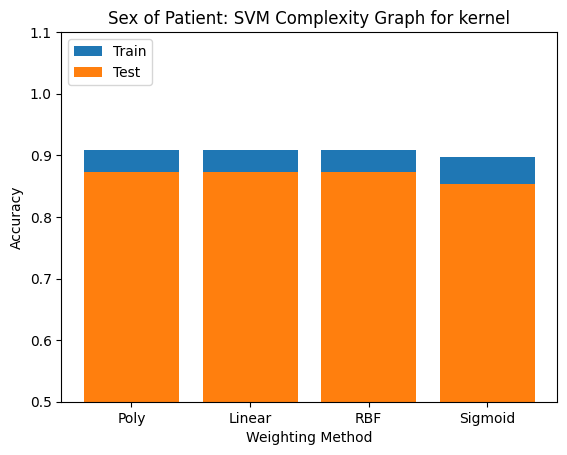

In [100]:
labels = ['Poly', 'Linear', 'RBF', 'Sigmoid']
test = [vm1.score(x_test, y_test), vm2.score(x_test, y_test), vm3.score(x_test, y_test), vm4.score(x_test, y_test)]
train = [vm1.score(x_train, y_train), vm2.score(x_train, y_train), vm3.score(x_train, y_train), vm4.score(x_train, y_train)]
plt.bar(labels, train)

plt.bar(labels, test)
plt.legend(["Train", "Test"], loc='upper left')
plt.title("Sex of Patient: SVM Complexity Graph for kernel")
plt.ylim((.5, 1.1))
plt.ylabel('Accuracy')
plt.xlabel('Weighting Method')
plt.savefig('./images/p9.1.png')

(0, 0.9015725101921956)


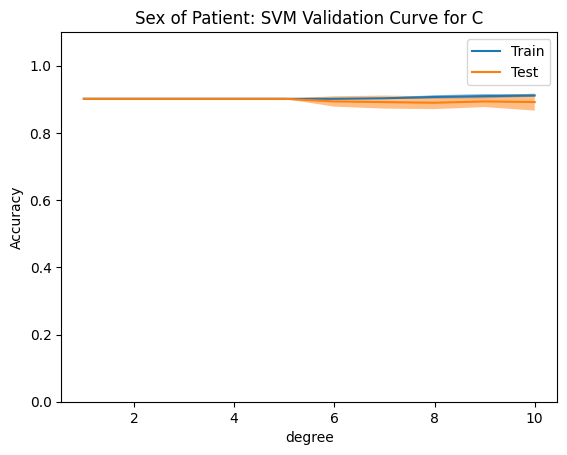

In [101]:
X, Y = seperate_columns()
X = X.drop(['RestingBP', 'RestingECG'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=0)

vm = svm.SVC(kernel='poly', random_state=0, tol=.001).fit(x_train, y_train)
plot = ValidationCurveDisplay.from_estimator(
    vm,
    X,
    Y,
    param_name="degree",
    param_range=[i for i in range(1, 11)],
    score_type="both",
    n_jobs=2,
    score_name="Accuracy",
)
plt.title("Sex of Patient: SVM Validation Curve for C")
plot.ax_.set_ylim((0, 1.1))
plt.savefig('./images/p9.2.png')
print(get_max_test_score_idx(plot))

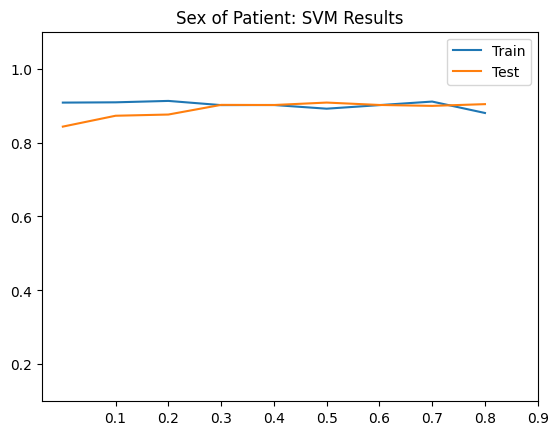

<Figure size 640x480 with 0 Axes>

In [102]:
X, Y = seperate_columns()
vm = svm.SVC(kernel='poly', random_state=0, degree = 3, tol=.001).fit(x_train, y_train)
evaluate_sk(vm, [i/10 for i in range(1, 10)], X, Y, './images/p9.3.png', 'Sex of Patient: SVM Results')

In [103]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as nf

torch.manual_seed(0)
df = load_data()



X = df.drop(columns=['Sex']).values
Y = df['Sex'].values
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

class HeartDiseaseClassifier(nn.Module):
    def __init__(self, input_size, dropout_rate=.7):
        
        super(HeartDiseaseClassifier, self).__init__()

        self.fc1 = nn.Linear(input_size, 256)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

        self.ru = nn.ReLU()

    def forward(self, x):

        x = self.fc1(x)
        x = self.ru(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.ru(x)

        x = self.fc3(x)
        x = self.ru(x)

        x = self.fc4(x)
        x = self.ru(x)

        x = self.fc5(x)
        x = self.sigmoid(x)
        return x

    def set_dropout_p(self, p):
        self.dropout = nn.Dropout(p=p)



def get_accuracy(x_to_measure, y_to_measure):
    with torch.no_grad():
        inputs = torch.Tensor(x_to_measure).float()
        labels = torch.Tensor(y_to_measure).view(-1, 1).float()
        outputs = model(inputs)
        predicted_train = (outputs > 0.5).float()
        return (predicted == labels).sum().item() / len(labels)


test_vals = []
train_vals = []


def train_model(num_epochs, drop_p=.5):
    input_size = x_train.shape[1]
    model = HeartDiseaseClassifier(input_size, drop_p)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    max = {'epoch': 0, 'max': 0}
    for epoch in range(num_epochs):
    
        inputs = torch.Tensor(x_train).float()
        labels = torch.Tensor(y_train).view((-1, 1)).float()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #test model ever 100 epochs
        if epoch % 100 == 0:
            test_val = score_nn(model, x_test, y_test)
            train_val = score_nn(model, x_train, y_train)
            test_vals.append(test_val)
            train_vals.append(train_val)

    return model
'''
epoch_values = [25 * i for i in range(1, 100)]
train_accuracy = [get_accuracy(train_model(e), x) for e in epoch_values]
print(epoch_values, accuracy)
'''



def score_nn(model, x, y):
    outputs = (model(torch.Tensor(x)) > .5).int()
    y = torch.Tensor(y).int().view(-1, 1)
    accuracy = (y == outputs).int().sum() / len(y)
    return float(accuracy)

model = train_model(2000)




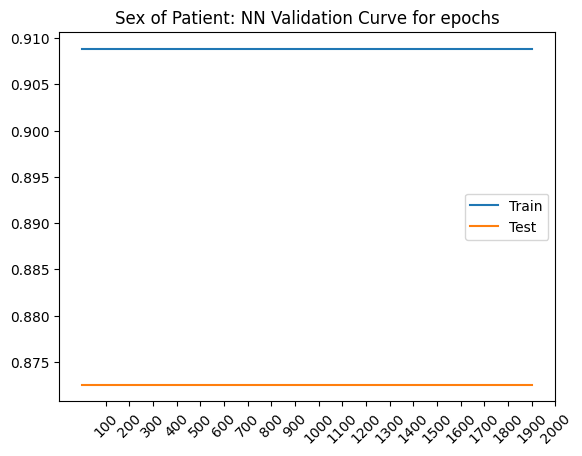

In [105]:
plt.plot(train_vals, label='Train')
plt.plot(test_vals, label='Test')
plt.xticks([i for i in range(1, 21)], [100 * i for i in range(1, 21)], rotation=45) 
plt.legend()
plt.title("Sex of Patient: NN Validation Curve for epochs")
plt.savefig('./images/p10.1.png')

In [106]:
#weird behavior, lets try with new models with diff p values for dropout
ps = [i/10 for i in range(1, 10)]
d_test_vals = []
d_train_vals = []

for p in ps:
    model = train_model(800, p)
    print('Trained')
    d_test_val = score_nn(model, x_test, y_test)
    d_train_val = score_nn(model, x_train, y_train)
    d_test_vals.append(d_test_val)
    d_train_vals.append(d_train_val)



Trained
Trained
Trained
Trained
Trained
Trained
Trained
Trained
Trained


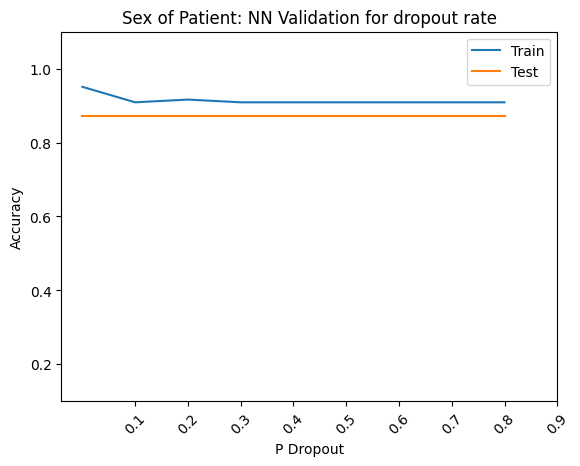

In [107]:
plt.plot(d_train_vals, label='Train')
plt.plot(d_test_vals, label='Test')
plt.xticks([i for i in range(1, 10)], [i/10 for i in range(1, 10)], rotation=45) 
plt.legend()
plt.ylim((.1, 1.1))
plt.xlabel("P Dropout")
plt.ylabel("Accuracy")
plt.title("Sex of Patient: NN Validation for dropout rate")
plt.savefig('./images/p10.2.png')


In [108]:
#test NN for multiple split values

X = df.drop(columns=['Sex']).values
Y = df['Sex'].values

def train_model(num_epochs, drop_p=.5):
    input_size = x_train.shape[1]
    model = HeartDiseaseClassifier(input_size, drop_p)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    max = {'epoch': 0, 'max': 0}
    for epoch in range(num_epochs):
    
        inputs = torch.Tensor(x_train).float()
        labels = torch.Tensor(y_train).view((-1, 1)).float()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #test model ever 100 epochs
        if epoch % 100 == 0:
            test_val = score_nn(model, x_test, y_test)
            train_val = score_nn(model, x_train, y_train)
            test_vals.append(test_val)
            train_vals.append(train_val)

    return model
p_test_vals = []
p_train_vals = []
for i in range(1, 10):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=i/10, random_state=0)
    
    model = train_model(800, .5)

    p_test_val = score_nn(model, x_test, y_test)
    p_train_val = score_nn(model, x_train, y_train)
    print(p_test_val)
    p_test_vals.append(p_test_val)
    p_train_vals.append(p_train_val)
    print(p_test_vals)



0.843137264251709
[0.843137264251709]
0.8725489974021912
[0.843137264251709, 0.8725489974021912]
0.8758170008659363
[0.843137264251709, 0.8725489974021912, 0.8758170008659363]
0.9019607901573181
[0.843137264251709, 0.8725489974021912, 0.8758170008659363, 0.9019607901573181]
0.8897637724876404
[0.843137264251709, 0.8725489974021912, 0.8758170008659363, 0.9019607901573181, 0.8897637724876404]
0.908196747303009
[0.843137264251709, 0.8725489974021912, 0.8758170008659363, 0.9019607901573181, 0.8897637724876404, 0.908196747303009]
0.9016854166984558
[0.843137264251709, 0.8725489974021912, 0.8758170008659363, 0.9019607901573181, 0.8897637724876404, 0.908196747303009, 0.9016854166984558]
0.8918918967247009
[0.843137264251709, 0.8725489974021912, 0.8758170008659363, 0.9019607901573181, 0.8897637724876404, 0.908196747303009, 0.9016854166984558, 0.8918918967247009]
0.903930127620697
[0.843137264251709, 0.8725489974021912, 0.8758170008659363, 0.9019607901573181, 0.8897637724876404, 0.9081967473030

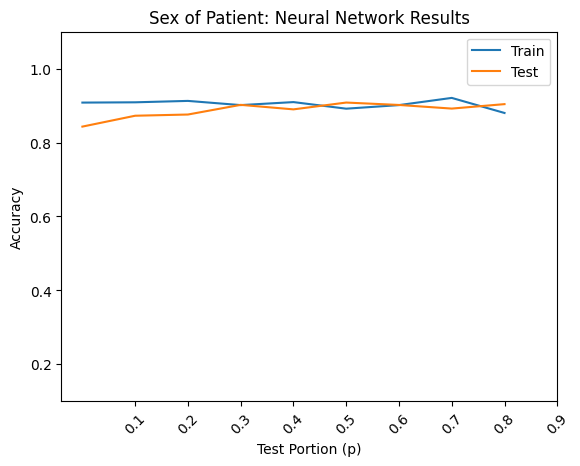

In [109]:
plt.plot(p_train_vals, label='Train')
plt.plot(p_test_vals, label='Test')
plt.xticks([i for i in range(1, 10)], [i/10 for i in range(1, 10)], rotation=45) 
plt.legend()
plt.ylim((.1, 1.1))
plt.xlabel("Test Portion (p)")
plt.ylabel("Accuracy")
plt.title("Sex of Patient: Neural Network Results")
plt.savefig('./images/p10.3.png')
